Metric learning aims to train models that can embed inputs into a high-dimensional space such that "similar" inputs, as defined by the training scheme, are located close to each other. These models once trained can produce embeddings for downstream systems where such similarity is useful; examples include as a ranking signal for search or as a form of pretrained embedding model for another supervised problem.

In [1]:
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras
from collections import defaultdict
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("Invalid device or cannot modify virtual devices once initialized.")

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
y_train = np.squeeze(y_train)
x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)

170500096/170498071 [==============================] - 39s 0us/step


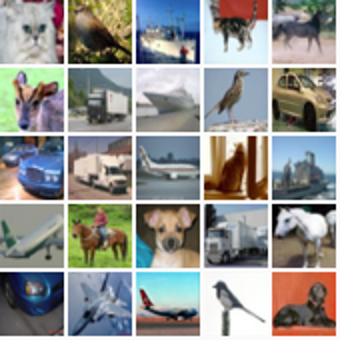

In [4]:
height_width = 32


def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode = "RGB",
        size = (num_cols * box_size, num_rows * box_size),
        color = (250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage


sample_idxs = np.random.randint(0, 50000, size = (5, 5))
examples = x_train[sample_idxs]
show_collage(examples)